In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import pandas as pd
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors


drive.mount('/content/drive')

# Ruta al archivo shapefile
shp_path =  '/content/drive/MyDrive/Tesis/Datos/v_camineria_nacional.shp'
roads = gpd.read_file(shp_path)

# Ver tipos y estructura
print(roads.columns)
print(roads.crs, roads.head())

# Filter the GeoDataFrame for route 8
route_8 = roads[roads['numero'] == 8]
route_8_proj = route_8.to_crs(32721)

Mounted at /content/drive
Index(['gid', 'codigo', 'numero', 'nombre', 'depto', 'jurisdicci', 'categoria',
       'sentido', 'carriles', 'calzada', 'fuente', 'observacio', 'nat_juridi',
       'geometry'],
      dtype='object')
EPSG:4326        gid     codigo  numero                        nombre depto  \
0  3344250  UY0110000    11.0         José Batlle y Ordoñez  UYCA   
1   349731  UY0110000    11.0         José Batlle y Ordoñez  UYCA   
2   292738  UY0270000    27.0                   Mario Heber  UYRV   
3   305834  UY0050000     5.0  Brig. Gral. Fructuoso Rivera  UYMO   
4  3343102   UYTA0284     NaN                          None  UYTA   

    jurisdicci                categoria  \
0     NACIONAL   CORREDOR INTERNACIONAL   
1     NACIONAL   CORREDOR INTERNACIONAL   
2     NACIONAL          RUTA SECUNDARIA   
3     NACIONAL   CORREDOR INTERNACIONAL   
4  SIN DEFINIR  CAMINERÍA DEPARTAMENTAL   

                                             sentido carriles        calzada  \
0  EL SEN

In [ ]:
csv_path =  '/content/drive/MyDrive/Tesis/Datos/Ruta8/remaining_route8_points.csv'
remaining_points = gpd.read_file(csv_path)
remaining_points.head()

,index,latitude,longitude
0,1,-34.734240819732456,-55.97548670651552
1,2,-34.7342490239945,-55.97567271040511
2,3,-34.64975647167261,-55.5626487299544
3,4,-34.64973612155217,-55.56222744021392
4,5,-34.649554126089896,-55.56210456722899


In [ ]:
paradas =  '/content/drive/MyDrive/Tesis/Datos/Ruta8/paradas_reales_con_coords.csv'
paradas = gpd.read_file(paradas)
paradas.head()

,image_path,image_name,index,lat,lon
0,/content/drive/MyDrive/Tesis/Datos/Ruta8/parad...,ruta8_pt_11276_z20.png,11276,-34.41447309963236,-55.36602791343036
1,/content/drive/MyDrive/Tesis/Datos/Ruta8/parad...,ruta8_pt_11279_z20.png,11279,-34.66305571092745,-55.61939256166202
2,/content/drive/MyDrive/Tesis/Datos/Ruta8/parad...,ruta8_pt_11286_z20.png,11286,-34.66276677366192,-55.61598647611578
3,/content/drive/MyDrive/Tesis/Datos/Ruta8/parad...,ruta8_pt_11287_z20.png,11287,-34.662706571603024,-55.615543322180166
4,/content/drive/MyDrive/Tesis/Datos/Ruta8/parad...,ruta8_pt_11603_z20.png,11603,-33.918241876116525,-54.77572280142126


In [ ]:
import geopandas as gpd
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    paradas.copy(),
    geometry=gpd.points_from_xy(paradas['lon'], paradas['lat']),
    crs="EPSG:4326"  # lat/lon WGS84
)

# Eliminacion de paradas repetidas

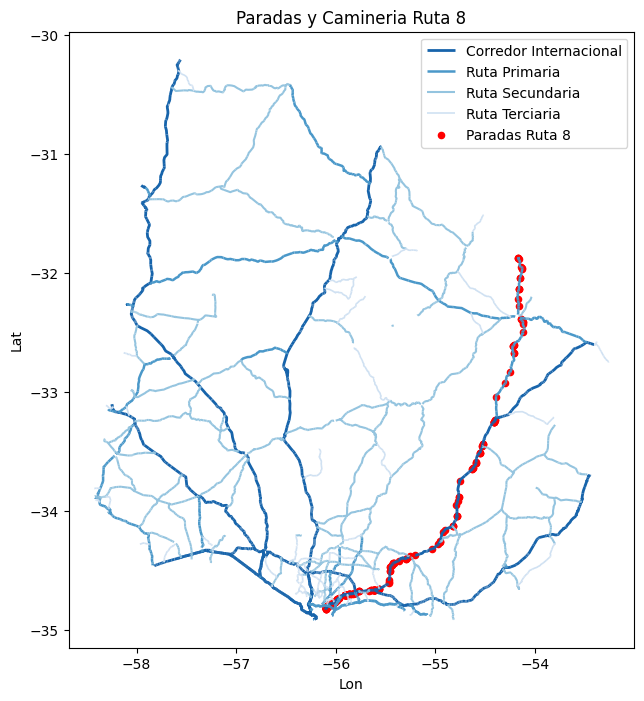

In [ ]:
# Filter out invalid geometries from roads
roads_valid = roads[roads.geometry.is_valid].reset_index(drop=True)

# Paleta de 4 azules distintos
azules = sns.color_palette("Blues", 4).as_hex()

def graficar_paradas(gdf, titulo = None):
  fig, ax = plt.subplots(figsize=(8,8))

  roads_valid[roads_valid["categoria"]=="CORREDOR INTERNACIONAL"].plot(
      ax=ax, color=azules[3], linewidth=2, label="Corredor Internacional"
  )
  roads_valid[roads_valid["categoria"]=="RUTA PRIMARIA"].plot(
      ax=ax, color=azules[2], linewidth=1.8, label="Ruta Primaria"
  )
  roads_valid[roads_valid["categoria"]=="RUTA SECUNDARIA"].plot(
      ax=ax, color=azules[1], linewidth=1.5, label="Ruta Secundaria"
  )
  roads_valid[roads_valid["categoria"]=="RUTA TERCIARIA"].plot(
      ax=ax, color=azules[0], linewidth=1.2, label="Ruta Terciaria"
  )


  # Plot the bus stops
  gdf.plot(ax=ax, color='red', markersize=20, label='Paradas Ruta 8')
  if titulo == None:
    ax.set_title("Paradas y Camineria Ruta 8")
  else:
    ax.set_title(titulo)
  ax.set_xlabel("Lon")
  ax.set_ylabel("Lat")
  plt.legend()
  plt.show()

graficar_paradas(gdf)

In [ ]:
gdf_m = gdf.to_crs(32721)

In [ ]:
repetidos = []

for i1, i in enumerate(gdf_m['geometry']):
  for j1, j in enumerate(gdf_m['geometry']):
    if i1 < j1 and i.distance(j) < 100:
      repetidos.append((i1, j1))

print("Number of pairs of points less than 50 meters apart:", len(repetidos))

Number of pairs of points less than 50 meters apart: 358


In [ ]:
projected_gdf = gdf_m

In [ ]:
from sklearn.cluster import DBSCAN

coords = np.column_stack([gdf_m.geometry.x.values, gdf_m.geometry.y.values])

# eps=1000 m, min_samples=1 -> cada punto queda en un cluster según conectividad por umbral
# (usa euclídea en metros porque estamos en UTM)
labels = DBSCAN(eps=100.0, min_samples=1, metric="euclidean").fit(coords).labels_

gdf_m = gdf_m.copy()
gdf_m["cluster_100"] = labels   # -1 sería "ruido" si min_samples>1

cluster_sizes = gdf_m.groupby("cluster_100").size().sort_values(ascending=False)

gdf_m = gdf_m.groupby('cluster_100').first()

gdf_m = gdf_m[['geometry']]

print(f"\nNumber of unique points after keeping one per cluster: {len(gdf_m)}")


Number of unique points after keeping one per cluster: 122


#Analisis de sistema de paradas en Ruta 8


In [ ]:
METRIC_CRS = 32721  # UTM 21S (Uruguay), en metros
PATH_LOCALIDADES = "/content/drive/MyDrive/Tesis/Datos/merged_localidades.csv"  # ajustá si cambia
RADIUS_KM = 5  # radio máximo "razonable" para asociar una parada a una localidad (opcional)

def ensure_metric_crs(gdf, metric_crs=METRIC_CRS):
    if gdf.crs is None:
        raise ValueError("GeoDataFrame sin CRS. Asigná/reproyectá antes.")
    return gdf if gdf.crs.to_epsg() == metric_crs else gdf.to_crs(epsg=metric_crs)

gdf_paradas = gdf_m.copy()
gdf_paradas.crs = f'EPSG:{METRIC_CRS}'
gdf_paradas = ensure_metric_crs(gdf_paradas, METRIC_CRS)
gdf_paradas = gdf_paradas[gdf_paradas.geometry.type == "Point"].copy()
gdf_paradas["x"] = gdf_paradas.geometry.x
gdf_paradas["y"] = gdf_paradas.geometry.y

loc = pd.read_csv(PATH_LOCALIDADES)
loc = loc.rename(columns={"size":"poblacion"})
loc.dropna(subset=['LON', 'LAT'], inplace=True)
gdf_loc_wgs = gpd.GeoDataFrame(
    loc,
    geometry=gpd.points_from_xy(loc["LON"], loc["LAT"]),
    crs=4326
)
gdf_loc = gdf_loc_wgs.to_crs(epsg=METRIC_CRS)

route8_union = route_8_proj.union_all()

# Distancia de cada localidad a la Ruta 8 (en metros)
gdf_loc["dist_ruta8_m"] = gdf_loc.geometry.distance(route8_union)

# Filtrar localidades a ≤ 10 km
MAX_KM_RUTA = 10
gdf_loc_valid = gdf_loc[gdf_loc["dist_ruta8_m"] <= MAX_KM_RUTA * 1000].copy()

print(f"Localidades dentro de {MAX_KM_RUTA} km de la Ruta 8: {len(gdf_loc_valid)} / {len(gdf_loc)}")

gdf_loc = gdf_loc_valid

Localidades dentro de 10 km de la Ruta 8: 80 / 462


Resumen distancias NN (m):
count      122.000000
mean      1861.096883
std       2980.949996
min        134.531270
10%        184.890600
25%        352.953764
50%        636.772278
75%       1476.165513
90%       6320.911127
95%       8817.354859
max      15228.345755
Name: dist_nn_m, dtype: float64


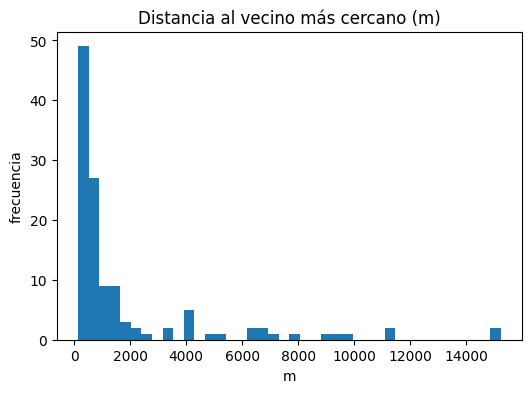

In [ ]:
#Distancia al vecino más cercano entre paradas
from sklearn.neighbors import NearestNeighbors

coords_p = np.c_[gdf_paradas["x"].to_numpy(), gdf_paradas["y"].to_numpy()]
nbrs_p = NearestNeighbors(n_neighbors=2, algorithm="ball_tree").fit(coords_p)
dists_p, idxs_p = nbrs_p.kneighbors(coords_p)
gdf_paradas["dist_nn_m"] = dists_p[:,1]  # col 1 = vecino más cercano (col 0 es el mismo punto)

print("Resumen distancias NN (m):")
print(gdf_paradas["dist_nn_m"].describe(percentiles=[0.1,0.25,0.5,0.75,0.9,0.95]))

plt.figure(figsize=(6,4))
plt.hist(gdf_paradas["dist_nn_m"], bins=40)
plt.title("Distancia al vecino más cercano (m)")
plt.xlabel("m")
plt.ylabel("frecuencia")
plt.show()


In [ ]:
# =========================
# Asignación de cada parada a la LOCALIDAD más cercana (usando SOLO las válidas)
# =========================

gdf_loc_valid = gdf_loc_valid.reset_index(drop=True)
coords_l = np.c_[gdf_loc_valid.geometry.x.to_numpy(), gdf_loc_valid.geometry.y.to_numpy()]
nbrs_l = NearestNeighbors(n_neighbors=1, algorithm="ball_tree").fit(coords_l)
coords_p = np.c_[gdf_paradas["x"].to_numpy(), gdf_paradas["y"].to_numpy()]
dists_pl, idxs_pl = nbrs_l.kneighbors(coords_p)

gdf_paradas["loc_idx"] = idxs_pl[:, 0]
gdf_paradas["dist_a_loc_m"] = dists_pl[:, 0]

# (Opcional) mantener tu umbral de “localidad razonable”
RADIUS_KM = 10
gdf_paradas["sin_localidad_cercana"] = gdf_paradas["dist_a_loc_m"] > (RADIUS_KM * 1000)

# Traer atributos de la localidad válida
cols_loc_keep = ["LOC_NOMBRE","DPTO_NOMBRE","poblacion","LOCALIDAD_CODE","DEPARTAMENTO","DPTO_CODIGO","DPTOLOC_COD","dist_ruta8_m"]
gdf_paradas = gdf_paradas.join(
    gdf_loc_valid[cols_loc_keep].reset_index(drop=True),
    on="loc_idx",
    rsuffix="_loc"
)

# =========================
# Agregación por localidad (solo localidades dentro de 20 km)
# =========================
agr = (
    gdf_paradas[~gdf_paradas["sin_localidad_cercana"]]
    .groupby("loc_idx")
    .agg(
        paradas=("geometry","count"),
        dist_nn_mediana=("dist_nn_m","median"),
        dist_nn_p95=("dist_nn_m", lambda s: np.percentile(s.dropna(),95) if len(s.dropna()) else np.nan),
        dist_media_a_loc_m=("dist_a_loc_m","mean"),
        dist_mediana_a_loc_m=("dist_a_loc_m","median")
    )
)

gdf_loc_agr = gdf_loc_valid.join(agr, how="left")
gdf_loc_agr["paradas"] = gdf_loc_agr["paradas"].fillna(0).astype(int)

gdf_loc_agr["paradas_por_1000"] = np.where(
    (gdf_loc_agr["poblacion"].notna()) & (gdf_loc_agr["poblacion"]>0),
    gdf_loc_agr["paradas"] / gdf_loc_agr["poblacion"] * 1000.0,
    np.nan
)
# =========================
# Visuales y export
# =========================
ranking = gdf_loc_agr[
    ["LOC_NOMBRE","DPTO_NOMBRE","poblacion","paradas","paradas_por_1000","dist_nn_mediana","dist_nn_p95",
     "dist_media_a_loc_m","dist_mediana_a_loc_m","dist_ruta8_m"]
].sort_values("paradas_por_1000", ascending=False)


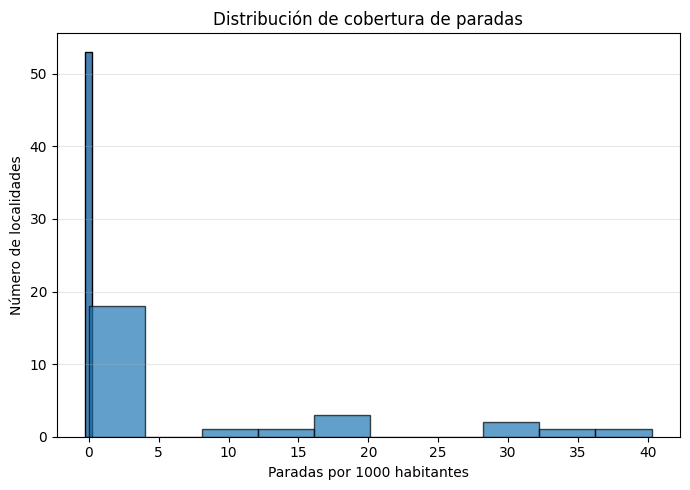

In [ ]:
vals = ranking["paradas_por_1000"]

# Separar las localidades con 0
zeros = vals[vals == 0]
nonzeros = vals[vals > 0]

plt.figure(figsize=(7,5))

# Barra especial para 0
plt.bar(0, len(zeros), width=0.5, color="steelblue", edgecolor="black")

# Histograma del resto (ajustando bins)
plt.hist(nonzeros, bins=10, edgecolor="black", alpha=0.7)

plt.xlabel("Paradas por 1000 habitantes")
plt.ylabel("Número de localidades")
plt.title("Distribución de cobertura de paradas")
plt.grid(axis="y", alpha=0.3)

# Etiqueta manual para la barra de 0
#plt.text(0, len(zeros)+0.5, f"{len(zeros)} localidades", ha="center")

plt.tight_layout()
plt.show()


In [ ]:
from shapely.ops import linemerge
CRS_METRIC = "EPSG:32721"

# Asegurar CRS y pasar a métrico
gdf_paradas = gdf_paradas.to_crs(CRS_METRIC)
gdf_loc_agr = gdf_loc_agr.to_crs(CRS_METRIC)
route_8 = route_8.to_crs(CRS_METRIC)
route_union = route_8.geometry.unary_union   # LineString o MultiLineString
route_line = linemerge(route_union)          # garantiza LineString

# Longitud de la ruta en km
route_length_km = route_line.length / 1000.0
print(f"Longitud de la ruta: {route_length_km:.1f} km")

# =========================
# Paradas a lo largo de la ruta
# =========================

# Coordenada "s" (distancia acumulada sobre la ruta) para cada parada
gdf_paradas["s_m"] = gdf_paradas.geometry.apply(route_line.project)
gdf_paradas["s_km"] = gdf_paradas["s_m"] / 1000.0

# Ordenar paradas por posición a lo largo de la ruta
gdf_paradas_sorted = gdf_paradas.sort_values("s_m").reset_index(drop=True)

# Distancia entre paradas consecutivas (en km)
s_vals = gdf_paradas_sorted["s_m"].to_numpy()
gap_m = np.diff(s_vals)
gap_km = gap_m / 1000.0

gdf_paradas_sorted.loc[1:, "dist_prev_km"] = gap_km
gdf_paradas_sorted.loc[0, "dist_prev_km"] = np.nan

print("Resumen distancias entre paradas (km):")
print(gdf_paradas_sorted["dist_prev_km"].describe())

# Densidad de paradas por km
stops_per_km = len(gdf_paradas) / route_length_km
print(f"Densidad de paradas: {stops_per_km:.2f} paradas/km")

# Huecos por encima de un umbral
GAP_THRESHOLD_KM = 2.0
gaps_mask = gap_km >= GAP_THRESHOLD_KM
print(f"Huecos >= {GAP_THRESHOLD_KM} km: {gaps_mask.sum()}")

# DataFrame de huecos: entre parada i y i+1
# s_vals tiene longitud n, gap_km tiene longitud n-1
s_vals = gdf_paradas_sorted["s_m"].to_numpy()
gap_m = np.diff(s_vals)
gap_km = gap_m / 1000.0

# DataFrame de huecos: entre parada i y i+1
gaps_df = pd.DataFrame({
    "stop_i": gdf_paradas_sorted.iloc[:-1]["s_km"].to_numpy(),   # 0 .. n-2
    "stop_i1": gdf_paradas_sorted.iloc[1:]["s_km"].to_numpy(),   # 1 .. n-1
    "gap_km": gap_km                                             # n-1
})

gaps_df = gaps_df[gaps_df["gap_km"] >= GAP_THRESHOLD_KM].reset_index(drop=True)

# =========================
# Distancia de localidades a paradas y a la ruta
# =========================

# Usamos centroides para medir distancia (si son polígonos)
loc_geom = gdf_loc_agr.geometry
if not all(loc_geom.geom_type == "Point"):
    loc_points = loc_geom.centroid
else:
    loc_points = loc_geom

# Matriz de coordenadas de paradas y localidades
stops_xy = np.vstack([gdf_paradas.geometry.x.to_numpy(),
                      gdf_paradas.geometry.y.to_numpy()]).T
loc_xy = np.vstack([loc_points.x.to_numpy(),
                    loc_points.y.to_numpy()]).T

# NN para distancia a parada más cercana
nn = NearestNeighbors(n_neighbors=1, algorithm="kd_tree")
nn.fit(stops_xy)
dist_loc_to_stop_m, idx_stop = nn.kneighbors(loc_xy, return_distance=True)
dist_loc_to_stop_m = dist_loc_to_stop_m.ravel()
idx_stop = idx_stop.ravel()

gdf_loc_agr["dist_stop_m"] = dist_loc_to_stop_m
gdf_loc_agr["dist_stop_km"] = dist_loc_to_stop_m / 1000.0
gdf_loc_agr["nearest_stop_id"] = gdf_paradas.iloc[idx_stop].index.to_numpy()

# Distancia de localidades a la ruta
gdf_loc_agr["dist_route_m"] = loc_points.distance(route_line)
gdf_loc_agr["dist_route_km"] = gdf_loc_agr["dist_route_m"] / 1000.0

print("Resumen distancias localidad → parada (m):")
print(gdf_loc_agr["dist_stop_m"].describe())

# =========================
# Paradas por 1000 habitantes por localidad
# =========================
gdf_paradas["dummy"] = 1  # por si queremos contar

# sjoin: asigna a cada parada la localidad que la contiene
paradas_en_loc = gpd.sjoin(
    gdf_paradas,
    gdf_loc_agr[["geometry"]],  # nos basta geometría para el join
    how="left",
    predicate="within"
).reset_index()

# Contar paradas por localidad (por índice de gdf_loc_agr)
stops_per_loc = (
    paradas_en_loc
    .groupby("index_right")
    .size()
    .rename("n_paradas")
    .to_frame()
)

gdf_loc_agr = gdf_loc_agr.join(stops_per_loc, how="left")
gdf_loc_agr["n_paradas"] = gdf_loc_agr["n_paradas"].fillna(0).astype(int)

# Paradas por 1000 hab
gdf_loc_agr["stops_per_1000"] = 1000 * gdf_loc_agr["n_paradas"] / gdf_loc_agr["poblacion"]

print("Resumen paradas por 1000 habitantes:")
print(gdf_loc_agr["stops_per_1000"].describe())

# =========================
# 5. DataFrame resumen global
# =========================

summary = {
    "n_paradas": len(gdf_paradas),
    "route_length_km": route_length_km,
    "stops_per_km": stops_per_km,
    "mean_gap_km": np.nanmean(gdf_paradas_sorted["dist_prev_km"]),
    "max_gap_km": np.nanmax(gdf_paradas_sorted["dist_prev_km"]),
    "mean_dist_loc_to_stop_m": gdf_loc_agr["dist_stop_m"].mean(),
    "median_dist_loc_to_stop_m": gdf_loc_agr["dist_stop_m"].median(),
}
R_LIST = [5000]
for R in R_LIST:
    total_pop = gdf_loc_agr["poblacion"].sum()
    total_cov_pop = gdf_loc_agr[f"cov_pop_R{R}m"].sum()
    summary[f"cov_R{R}m_pct"] = 100 * total_cov_pop / total_pop

summary_df = pd.DataFrame([summary])
print(summary_df)


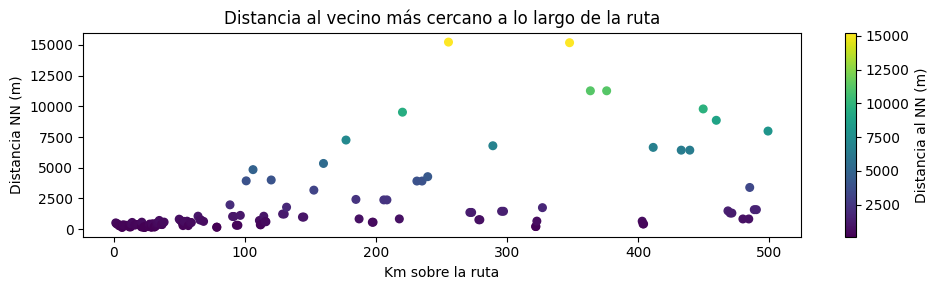

In [ ]:
plt.figure(figsize=(10,3))
plt.scatter(gdf_paradas_sorted["s_km"],
            gdf_paradas_sorted["dist_nn_m"],
            c=gdf_paradas_sorted["dist_nn_m"],
            cmap="viridis", s=30)

plt.colorbar(label="Distancia al NN (m)")
plt.xlabel("Km sobre la ruta")
plt.ylabel("Distancia NN (m)")
plt.title("Distancia al vecino más cercano a lo largo de la ruta")
plt.tight_layout()
plt.show()

#Creacion del nuevo sistema de paradas en Ruta 8


## Siguiendo el paper Yuan Zhu y Jingqiao Yu

In [ ]:
import math
from dataclasses import dataclass
from typing import Tuple, Optional
from shapely.ops import unary_union, linemerge, snap
from shapely.geometry import LineString, MultiLineString, Point
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans

def _merged_route_line(roads: gpd.GeoDataFrame,S = 100)-> list:
    u = unary_union(roads.geometry.values)
    u = snap(u, u, S)       # cierra micro-gaps reales
    merged = linemerge(u)
    parts = merged.geoms if isinstance(merged, MultiLineString) else [merged]
    lines = sorted(list(merged.geoms), key=lambda g: (g.bounds[1], g.bounds[0]))
    return lines

def points_every(line, step) -> list:
    L = line.length
    d = 0.0
    pts = []
    while d <= L:
        pts.append(line.interpolate(d))
        d += step
    return pts

def _snap_point_to_line_and_m(point: Point, line) -> Tuple[Point, float]:
    """
    Snaps a point to a LineString or MultiLineString and returns the snapped point
    and the m-value (distance along the line from the start).
    """
    from shapely.ops import nearest_points

    if isinstance(line, LineString):
        snapped = nearest_points(point, line)[0]
        coords = list(line.coords)
        dists = [0.0]
        for i in range(1, len(coords)):
            dists.append(dists[-1] + Point(coords[i-1]).distance(Point(coords[i])))
        total_len = dists[-1]
        min_dist = float("inf"); seg_idx = 0
        for i in range(1, len(coords)):
            seg = LineString([coords[i-1], coords[i]])
            d = snapped.distance(seg)
            if d < min_dist:
                min_dist = d; seg_idx = i
        a = Point(coords[seg_idx-1]); b = Point(coords[seg_idx])
        ab = np.array([b.x - a.x, b.y - a.y])
        ap = np.array([snapped.x - a.x, snapped.y - a.y])
        seg_len = np.linalg.norm(ab)
        t = 0.0 if seg_len == 0 else np.clip(np.dot(ap, ab) / (seg_len**2), 0, 1)
        m = dists[seg_idx-1] + t * seg_len
        return snapped, m

    elif isinstance(line, MultiLineString):
        min_dist = float("inf")
        best_snapped = None
        best_m = 0.0
        total_len_so_far = 0.0

        for segment in line.geoms:
            try:
                snapped_seg, m_seg = _snap_point_to_line_and_m(point, segment)
                dist_to_segment = point.distance(snapped_seg)

                if dist_to_segment < min_dist:
                    min_dist = dist_to_segment
                    best_snapped = snapped_seg
                    # Calculate m-value along the *entire* MultiLineString
                    best_m = total_len_so_far + m_seg
            except Exception:
                # Handle cases where snapping to a small segment might fail
                pass
            total_len_so_far += segment.length

        if best_snapped is None:
             # If snapping failed for all segments, return a default or raise error
             # For now, return the original point and 0 m-value as a fallback
             return point, 0.0 # Or raise an informative error

        return best_snapped, best_m

    else:
        raise TypeError("Input geometry must be a LineString or MultiLineString")


# --- Candidate generation ---
#espaciar cada 3 km

def make_candidates_along_route(roads: gpd.GeoDataFrame, spacing_m: int = 3000):
    route_line_segments = _merged_route_line(roads)
    pts = []
    Distancia = 0
    for tramo in route_line_segments:
        if Distancia > spacing_m:
          puntos = points_every(tramo, spacing_m)
          for punto in puntos:
              pts.append(punto)
          Distancia = 0
        else:
          Distancia += tramo.length

    return gpd.GeoDataFrame({"cand_id": range(len(pts))}, geometry=pts, crs=roads.crs)
                      ##################################################################
                      ###################### hasta aca funciona  #######################
                      ##################################################################
def expand_candidates(candidates, roads, expand_m: int = 500):
    route_line_segments = _merged_route_line(roads)
    new_pts = []
    # Consider a small buffer for proximity check
    buffer_distance = 1.0 # meters, adjust as needed

    for p in candidates.geometry:
        for tramo in route_line_segments:
            # Check if the point is within a small buffer of the line segment
            if p.within(tramo.buffer(buffer_distance)):
                _, m = _snap_point_to_line_and_m(p, tramo)
                for delta in (-expand_m, 0, +expand_m):
                    md = max(0, min(tramo.length, m + delta))
                    new_pts.append(tramo.interpolate(md))
                # Once a segment is found, no need to check others for this point
                break

    return gpd.GeoDataFrame(geometry=new_pts, crs=roads.crs).drop_duplicates(ignore_index=True)

In [ ]:

# --- Clustering ---
def kmeans_centers(demand_pts: gpd.GeoDataFrame, k: int):
    X = np.c_[demand_pts.geometry.x, demand_pts.geometry.y]
    km = KMeans(n_clusters=k, n_init="auto", random_state=42)
    labels = km.fit_predict(X)
    centers = km.cluster_centers_
    counts = pd.Series(labels).value_counts().sort_index().to_numpy()
    return gpd.GeoDataFrame({"weight": counts}, geometry=[Point(xy) for xy in centers], crs=demand_pts.crs)

# --- WPDM scoring ---
####### REVISAR
####### Por que proyecta en la ruta las ciudades, los candidatos ya van a estar en la ruta
import numpy as np
import pandas as pd
from pyproj import CRS


def wpdm_scores(candidates, centers, shortlist_k: int = 3, rank_weights=(1.0, 0.5, 0.2)):
    """
    candidates: GeoSeries (puntos) o array de floats (distancias euclídeas si no es Geo)
    centers: GeoDataFrame con columnas: geometry (Point) y weight (float)
    """
    shortlist_k = int(shortlist_k)
    if shortlist_k < 1:
        raise ValueError("shortlist_k debe ser >= 1")

    # Asegurar pesos suficientes (relleno con 0: más allá de los 3 primeros no suma)
    rweights = np.array(rank_weights, dtype=float)
    if len(rweights) < shortlist_k:
        rweights = np.pad(rweights, (0, shortlist_k - len(rweights)), constant_values=0.0)

    scores = np.zeros(len(candidates), dtype=float)

    use_geo = hasattr(candidates, "distance") and hasattr(centers, "geometry")
    center_weights = np.asarray(centers["weight"], dtype=float)

    for i, w in enumerate(center_weights):
        if use_geo:
            dists = np.asarray(candidates.distance(centers.geometry.iloc[i]))
        else:
            # si no es Geo, asumir candidatos y centers son arrays/series numéricas comparables
            dists = np.abs(np.asarray(candidates) - np.asarray(centers.iloc[i]))

        # Elegir los k más cercanos y ordenarlos por distancia
        k = min(shortlist_k, len(dists))
        idx = np.argpartition(dists, k-1)[:k]
        idx = idx[np.argsort(dists[idx])]
        scores[idx] += w * rweights[:k]

    return pd.DataFrame({"score": scores})

def select_top_n_with_min_spacing(
    candidates: gpd.GeoDataFrame,
    scores: pd.DataFrame,
    n: int,
    min_spacing_m: float = 100.0,
    score_col: str = "score",
    metric_crs: str = "EPSG:32721",  # UTM 21S (Uruguay): distancias en metros
):
    # --- Validaciones ---
    if not isinstance(candidates, gpd.GeoDataFrame):
        raise TypeError("candidates debe ser un GeoDataFrame.")
    if score_col not in scores.columns:
        raise ValueError(f"'{score_col}' no existe en scores.")
    if len(scores) != len(candidates):
        raise ValueError("candidates y scores deben tener el mismo largo (1:1).")
    if candidates.crs is None:
        raise ValueError("El GeoDataFrame no tiene CRS. Define uno (WGS84, etc.).")

    # Deben ser puntos
    if not (candidates.geometry.geom_type == "Point").all():
        raise ValueError("La geometría debe ser de tipo Point en todas las filas.")

    # --- Trabajar en metros ---
    crs_obj = CRS.from_user_input(candidates.crs)
    g = candidates
    if crs_obj.is_geographic:
        # reproyectamos a CRS en metros (por defecto UTM 21S)
        g = candidates.to_crs(metric_crs)

    # --- Selección ávida por score con espaciamiento mínimo ---
    order = (
        pd.DataFrame({"idx": np.arange(len(g)), "score": scores[score_col].to_numpy()})
        .dropna(subset=["score"])
        .sort_values("score", ascending=False)["idx"]
        .to_list()
    )

    chosen = []
    for idx in order:
        if len(chosen) >= n:
            break
        geom = g.geometry.iloc[idx]
        # distancia mínima al conjunto ya elegido
        if not chosen:
            chosen.append(idx)
            continue
        dmin = min(geom.distance(g.geometry.iloc[j]) for j in chosen)
        if dmin >= float(min_spacing_m):
            chosen.append(idx)

    out = candidates.iloc[chosen].copy()
    out[score_col] = scores.iloc[chosen][score_col].to_numpy()
    return out.sort_values(score_col, ascending=False).reset_index(drop=True)


In [ ]:
#@title COMENTARIO !!!

#Los linestrings se SOLAPAN, haciendo que se contabilice varias veces un mismo tramo

# Create a GeoDataFrame from the list of LineStrings
tramo_gdf = gpd.GeoDataFrame(geometry=_merged_route_line(route_8_proj))

# Generate a color gradient from black to white
num_segments = len(tramo_gdf)
colors = [plt.cm.gray(i/num_segments) for i in range(num_segments)]

# Assign a color to each segment
tramo_gdf['color'] = colors

# Get the coordinates of Montevideo from gdf_loc_agr
montevideo_coords = gdf_loc[gdf_loc['LOC_NOMBRE'] == 'MONTEVIDEO'].geometry.iloc[0]
# Define the zoom level in meters
zoom_level_m = 180 * 1000

# Create a new plot for the route segments with markers and zoom
fig, ax = plt.subplots(figsize=(20,15))

# Plot the GeoDataFrame with the color gradient
tramo_gdf.plot(ax=ax, color=tramo_gdf['color'])

# Add start and end markers for each segment of route_8_proj
route_line_segments = _merged_route_line(route_8_proj)
for segment in route_line_segments:
    start_point = segment.coords[0]
    end_point = segment.coords[-1]
    ax.plot(start_point[0], start_point[1], 'D', color='red', markersize=5) # Red diamond for start
    ax.plot(end_point[0], end_point[1], 'X', color='green', markersize=5) # Green X for end

ax.set_title("Route 8 Segments with Start/End Markers (Montevideo Area)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Apply the zoom
ax.set_xlim([montevideo_coords.x - zoom_level_m, montevideo_coords.x + zoom_level_m])
ax.set_ylim([montevideo_coords.y - zoom_level_m, montevideo_coords.y + zoom_level_m])

plt.show()

IndexError: single positional indexer is out-of-bounds

In [ ]:
# ahp.py
"""
Minimal AHP utilities.
"""
import numpy as np

RI_TABLE = {
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45,
    10: 1.49, 11: 1.51, 12: 1.48, 13: 1.56, 14: 1.57, 15: 1.59
}

def build_pairwise_matrix(items, comparisons, check_scale=True):
    """
    Construye la matriz de comparaciones por pares A (n x n) donde A[i,j] = importancia de i sobre j.
    - items: lista ordenada de nombres (criterios o alternativas).
    - comparisons: dict {(i,j): valor} en escala de Saaty 1–9 (o cualquier razón positiva).
      Solo hace falta consignar (i,j) o (j,i); el recíproco se completa automáticamente.
    - check_scale: si True, avisa si un valor queda fuera de [1/9, 9].
    Devuelve (A, labels).
    """
    labels = list(items)
    n = len(labels)
    idx = {name: k for k, name in enumerate(labels)}
    A = np.ones((n, n), dtype=float)
    for (i, j), v in comparisons.items():
        if i not in idx or j not in idx:
            raise ValueError(f"Unknown item in comparison: {(i,j)}")
        if v <= 0:
            raise ValueError("Comparison values must be positive.")
        if check_scale and not (1/9 <= v <= 9):
            print(f"Warning: value {v} for ({i},{j}) is outside Saaty 1..9 (or reciprocal). Proceeding.")
        A[idx[i], idx[j]] = v
        A[idx[j], idx[i]] = 1.0 / v
    np.fill_diagonal(A, 1.0)
    return A, labels

def ahp_weights(A, method="eigen"):
    """
    Calcula el vector de prioridades w a partir de la matriz A.
    method:
      - 'eigen': autovector principal (método original de Saaty)
      - 'geom': media geométrica por fila (aprox. robusta)
    Devuelve dict con:
      {
        'weights': np.array shape (n,),
        'lambda_max': float,
        'CI': float,
        'CR': float
      }
    """
    A = np.asarray(A, dtype=float)
    if A.ndim != 2 or A.shape[0] != A.shape[1]:
        raise ValueError("A must be a square matrix.")
    n = A.shape[0]

    if method == "eigen":
        vals, vecs = np.linalg.eig(A)
        idx = np.argmax(vals.real)
        w = vecs[:, idx].real
        w = np.abs(w)
    elif method == "geom":
        w = np.prod(A, axis=1) ** (1.0 / n)
    else:
        raise ValueError("method must be 'eigen' or 'geom'")

    w = w / w.sum()

    Aw = A @ w
    lambda_max = float((Aw / w).mean())
    CI = (lambda_max - n) / (n - 1) if n > 1 else 0.0
    RI = RI_TABLE.get(n, RI_TABLE[max(k for k in RI_TABLE if k <= n)])
    CR = CI / RI if RI > 0 else 0.0
    return {"weights": w, "lambda_max": lambda_max, "CI": CI, "CR": CR}

# ejemplo_ahp.py
import numpy as np

# Criterios
labels = ["POI_number", "Stops_spacing", "Stop_POI_distance"]

# Comparaciones por pares (escala de Saaty)
comparisons = {
    ("POI_number", "Stops_spacing"): 3,    # POI moderadamente > spacing
    ("POI_number", "Stop_POI_distance"): 2,# POI fuertemente > dist
    ("Stops_spacing", "Stop_POI_distance"): 0.5  # spacing ligeramente > dist
}

A, _ = build_pairwise_matrix(labels, comparisons)
res = ahp_weights(A, method="eigen")
pesos = np.round(res["weights"])
print("Matriz A:\n", np.round(A, 3))
print("Pesos:", np.round(res["weights"], 6))
print("lambda_max:", round(res["lambda_max"], 6), "CI:", round(res["CI"], 6), "CR:", round(res["CR"], 6))


Matriz A:
 [[1.    3.    2.   ]
 [0.333 1.    0.5  ]
 [0.5   2.    1.   ]]
Pesos: [0.539615 0.163424 0.296961]
lambda_max: 3.009203 CI: 0.004601 CR: 0.007933


In [ ]:
# --- AHP evaluation ---
@dataclass
class AHPWeights:
    poi_number: float = 0.539615
    stop_spacing: float = 0.163424
    poi_distance: float = 0.296961

def evaluate_stops_ahp(stops, roads, pois, weights=AHPWeights()):
    # Get the merged route geometry (can be LineString or MultiLineString)
    route_geometry = unary_union(roads.geometry.values)

    # Calculate m-values by snapping each stop to the route geometry
    mvals = stops.geometry.apply(lambda p: _snap_point_to_line_and_m(p, route_geometry)[1]).sort_values().to_numpy()

    spacings = np.diff(mvals) if len(mvals)>1 else [0]
    sp_full = np.r_[spacings[0], (spacings[:-1]+spacings[1:])/2.0, spacings[-1]] if len(mvals)>1 else [0]*len(mvals)
    #distancias entre paradas
    #distancias a mirar en el futuro, y adaptarlas segun poblacion
    spacing_score = pd.Series([1.0 if 2000<d<=15000 else 0.5 if d<=25000 else 0.2 for d in sp_full], index=stops.index)
    counts = stops.buffer(5000).apply(lambda b: pois.within(b).sum())
    #cantidad de localidades de cercanas
    poi_num_score = counts.apply(lambda c: 0.3 if c<=1 else 0.6 if c<=3 else 0.8 if c<=10 else 1.0)
    poi_dist_score = []
    #distancia promedio a las localidades mas cercanas
    for _, s in stops.iterrows():
        d = pois.distance(s.geometry)
        mask = d <= 5000
        if mask.any():
            avg = d[mask].mean()
            sc = 1.0 if avg<=2000 else 0.7 if avg<=3500 else 0.5
        else: sc = 0.5
        poi_dist_score.append(sc)
    poi_dist_score = pd.Series(poi_dist_score, index=stops.index)
    #calcula la metrica
    total = (weights.poi_number*poi_num_score +
             weights.stop_spacing*spacing_score +
             weights.poi_distance*poi_dist_score)
    df = pd.DataFrame({"poi_num": poi_num_score, "spacing": spacing_score,
                       "poi_dist": poi_dist_score, "total_score": total})
    df.attrs["overall_mean"] = float(total.mean())
    return df

def optimize_single_corridor(roads, demand_pts, pois, n_new_stops, k_clusters=None,
                             spacing_m=3000, expand_m=1500, shortlist_k=3, min_spacing_m=100):
    candidates = make_candidates_along_route(roads, spacing_m)
   # print(f"Candidates: {len(candidates)}")
    candidates2 = expand_candidates(candidates, roads, expand_m)
   # print(f"2 Candidates: {len(candidates2)}")
    if k_clusters is None:
        k_clusters = min(20, max(5, int(np.sqrt(len(demand_pts)))))
    centers = kmeans_centers(demand_pts, k=k_clusters)
    sc = wpdm_scores(candidates2, centers, shortlist_k) # Removed 'roads' argument
    #print(f"Scores: {len(sc)}")
    new_stops = select_top_n_with_min_spacing(candidates2, sc, n=n_new_stops, min_spacing_m=min_spacing_m)
    #print(f"New stops: {new_stops.shape[0]}")
    return new_stops, sc

In [ ]:
benchmark = evaluate_stops_ahp(gdf_paradas, route_8_proj, gdf_loc_agr)['total_score']
print("Benchmark (mean):", benchmark.mean())

## Optimizacion

[I 2025-11-19 10:04:48,966] Trial 215 finished with value: 0.5641435759999999 and parameters: {'spacing_m': 4187, 'expand_m': 1021, 'shortlist_k': 5, 'min_spacing_m': 156, 'paradas': 50, 'k_clusters': 34}. Best is trial 215 with value: 0.5641435759999999.


In [ ]:
#print("Mejores hiperparámetros:", study.best_params)
#print("AHP mean (max):", study.best_value)

# Recalcular con el mejor set
#bp = study.best_params
new_stops_opt, wpdm_opt = optimize_single_corridor(
    roads=route_8_proj,
    demand_pts=gdf_loc_agr,
    pois=gdf_loc_agr,
    n_new_stops=50,
    k_clusters=34,
    spacing_m=4187,
    expand_m=1021,
    shortlist_k=5,
    min_spacing_m=156
)

eval_opt = evaluate_stops_ahp(new_stops_opt, route_8_proj, gdf_loc_agr)


In [ ]:
print(roads_valid.crs)

EPSG:4326


0.5641435759999999
cantidad de paradas 50


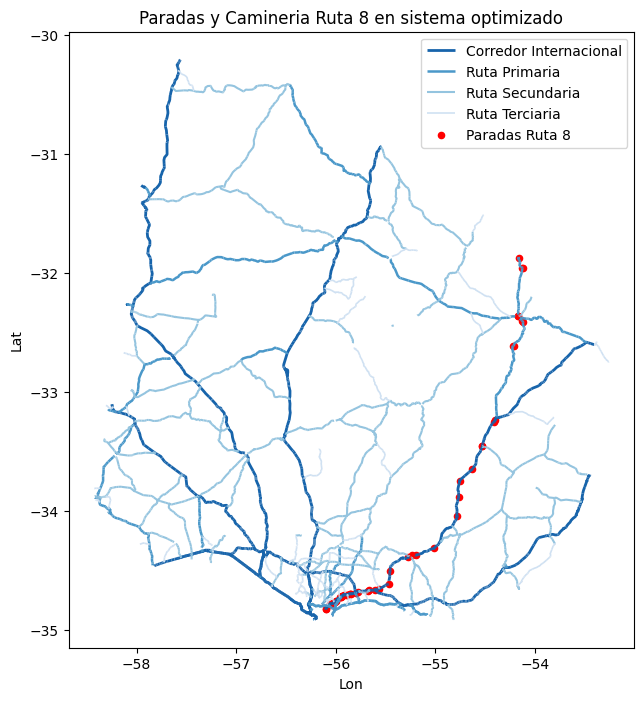

In [ ]:
float(eval_opt["total_score"].mean())
print(float(eval_opt["total_score"].mean()))
print("cantidad de paradas", len(new_stops_opt))
new_stops_opt_ = new_stops_opt.to_crs("EPSG:4326")
graficar_paradas(new_stops_opt_, titulo = "Paradas y Camineria Ruta 8 en sistema optimizado")

In [ ]:
!pip install optuna --quiet

In [ ]:
import optuna
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def objective(trial: optuna.Trial):
    # --- ESPACIO RURAL ---
    spacing_m     = trial.suggest_int("spacing_m", 2000, 40000)      # separación base de candidatos
    expand_m      = trial.suggest_int("expand_m", min(1000,spacing_m//3), min(3500, spacing_m//2))         # micro-ajuste local
    shortlist_k   = trial.suggest_categorical("shortlist_k", [2,3,4,5,6,7])
    min_spacing_m = trial.suggest_int("min_spacing_m", 150, 500)
    paradas = trial.suggest_int("paradas", 50, 200)

    # k_clusters moderado (rural): entre ~sqrt(N) N
    lo_k = len(gdf_loc_agr)//30
    hi_k = len(gdf_loc_agr)//2
    k_clusters   = trial.suggest_int("k_clusters", lo_k, hi_k)

    new_stops_try, wpdm_try = optimize_single_corridor(
        roads=route_8_proj,
        demand_pts=gdf_loc_agr,
        pois=gdf_loc_agr,           # si por ahora POIs=demanda como proxy, mantenemos consistencia
        n_new_stops=paradas,
        k_clusters=k_clusters,
        spacing_m=spacing_m,
        expand_m=expand_m,
        shortlist_k=shortlist_k,
        min_spacing_m=min_spacing_m
    )
    eval_try = evaluate_stops_ahp(new_stops_try, route_8_proj, gdf_loc_agr)
    score_mean = float(eval_try["total_score"].mean())
    #graficar_paradas(new_stops_try)
    return score_mean
def optimizar_paradas():
  study = optuna.create_study(
      direction="maximize",
      sampler=TPESampler(seed=42),
      pruner=MedianPruner(n_warmup_steps=10),
      study_name="ruta8_rural_wpdm_ahp"
  )

  study.optimize(objective, n_trials=300, show_progress_bar=True)
  return study

In [ ]:
"""# Save the eval_opt DataFrame to a CSV file
eval_opt.to_csv('/content/drive/MyDrive/Tesis/Datos/Ruta8/eval_opt.csv')

# Save the best parameters to a text file
with open('/content/drive/MyDrive/Tesis/Datos/Ruta8/best_params.txt', 'w') as f:
    for key, value in bp.items():
        f.write(f"{key}: {value}\n")

print("eval_opt and best_params saved to Google Drive.")"""

In [ ]:
azules = sns.color_palette("Blues", 4).as_hex()

# Map the 'categoria' column to marker sizes
gdf_loc_agr["marker_size"] = gdf_loc_agr["categoria"].map(marker_sizes)

ax = gdf_loc_agr.plot(
    figsize=(20,15),
    markersize="marker_size",
    column="categoria",
    legend=True
)

roads_valid[roads_valid["categoria"]=="CORREDOR INTERNACIONAL"].plot(
    ax=ax, color=azules[3], linewidth=2, label="Corredor Internacional"
)
roads_valid[roads_valid["categoria"]=="RUTA PRIMARIA"].plot(
    ax=ax, color=azules[2], linewidth=1.8, label="Ruta Primaria"
)
roads_valid[roads_valid["categoria"]=="RUTA SECUNDARIA"].plot(
    ax=ax, color=azules[1], linewidth=1.5, label="Ruta Secundaria"
)
roads_valid[roads_valid["categoria"]=="RUTA TERCIARIA"].plot(
    ax=ax, color=azules[0], linewidth=1.2, label="Ruta Terciaria"
)

gdf_paradas.plot(ax=ax, marker='D', color="black", markersize=40, label = 'original stops',
    legend=True)
new_stops_opt.plot(ax=ax, marker='X', color="pink", markersize=80, label = 'new stops',
    legend=True)

#route_8_proj.plot(ax=ax, linewidth=1.5, color="black")  # trazo de la ruta
ax.set_title("Paradas por 1.000 hab (localidades ≤20 km de Ruta 8)")

plt.show()

## Algoritmos evolutivos

In [ ]:
!pip install deap --quiet

In [ ]:
import numpy as np, random, multiprocessing as mp
from functools import lru_cache
from deap import base, creator, tools, algorithms

# --- Hiperparámetros (ajustables) ---
N = 60              # número de paradas
dmin = 1000       # separación mínima (m)
POP = 120           # tamaño población
GEN = 60            # generaciones máx
CX_P = 0.7          # prob cruce
MUT_P = 0.3         # prob mutación
TOUR = 3            # torneo
EARLY_NI = 10       # cortar si no mejora en 10 gens
candidates = make_candidates_along_route(route_8_proj, dmin)

In [ ]:

# ====== PRE-COMPUTOS ======
# Asegurate de tener candidates en CRS métrico (no WGS84). Ejemplo:
# candidates = candidates.to_crs(32721)   # UTM 21S
ALL_IDX = np.arange(len(candidates), dtype=int)

def _precompute_too_close_neighbors(candidates, dmin):
    from sklearn.neighbors import KDTree
    xy = np.array([(p.x, p.y) for p in candidates.geometry.to_numpy()], dtype=float)
    tree = KDTree(xy)
    idxs = tree.query_radius(xy, r=dmin)
    out = []
    for i, arr in enumerate(idxs):
        s = set(arr.tolist())
        s.discard(i)
        out.append(s)
    return out

too_close = _precompute_too_close_neighbors(candidates, dmin)
too_close_sets = [set(s) for s in too_close]

# ====== FITNESS con caché y penalización ======
try:
    creator.FitnessMax
except AttributeError:
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

@lru_cache(maxsize=10000)
def _fitness_from_tuple(sol_tuple):
    idx = np.fromiter(sol_tuple, dtype=int)
    chosen = set(idx.tolist())
    # Chequeo O(N * grado) muy rápido
    for i in idx:
        if too_close_sets[i] & chosen:
            return -1e9  # penalización dura: evita llamar AHP
    # Solo si es factible, llamamos a tu función cara:
    sc = evaluate_stops_ahp(candidates.iloc[idx], roads=route_8_proj, pois=gdf_loc_agr)
    return float(np.mean(sc["total_score"]))

def evaluate_individual(ind):
    return (_fitness_from_tuple(tuple(ind)),)

# ====== OPERADORES FEASIBLES ======
def init_individual():
    ind, available = [], set(ALL_IDX.tolist())
    while len(ind) < N and available:
        i = random.sample(list(available), 1)[0]
        ind.append(i)
        # bloquear vecinos a < dmin
        available -= (too_close_sets[i] | {i})
    # reparación greedy si faltan genes
    if len(ind) < N:
        rem = list(set(ALL_IDX) - set(ind))
        random.shuffle(rem)
        for j in rem:
            if all((j not in too_close_sets[k]) for k in ind):
                ind.append(j)
                if len(ind) == N: break
    return creator.Individual(sorted(ind))

def cx_repair(ind1, ind2):
    # mezcla por unión parcial y repara factibilidad
    pool = list(set(ind1) | set(random.sample(ind2, k=N//2)))
    child = []
    used = set()
    for i in sorted(pool):
        if all((i not in too_close_sets[j]) for j in child):
            child.append(i); used.add(i)
        if len(child) == N: break
    if len(child) < N:
        rest = list(set(ALL_IDX) - used)
        random.shuffle(rest)
        for i in rest:
            if all((i not in too_close_sets[j]) for j in child):
                child.append(i)
                if len(child) == N: break
    ind1[:] = sorted(child)
    # hijo 2: simétrico pero con roles invertidos
    pool2 = list(set(ind2) | set(random.sample(ind1, k=N//2)))
    child2, used2 = [], set()
    for i in sorted(pool2):
        if all((i not in too_close_sets[j]) for j in child2):
            child2.append(i); used2.add(i)
        if len(child2) == N: break
    if len(child2) < N:
        rest2 = list(set(ALL_IDX) - used2)
        random.shuffle(rest2)
        for i in rest2:
            if all((i not in too_close_sets[j]) for j in child2):
                child2.append(i)
                if len(child2) == N: break
    ind2[:] = sorted(child2)
    return ind1, ind2

def mut_targeted(ind, k=None):
    if k is None: k = max(1, N//10)
    cur = set(ind)
    # remover hasta k genes más conflictivos
    for _ in range(k):
        conflicts = [(i, len(too_close_sets[i] & cur)) for i in list(cur)]
        i_bad, cmax = max(conflicts, key=lambda t: t[1])
        if cmax == 0: break
        cur.remove(i_bad)
    # rellenar con índices que no choquen
    pool = list(set(ALL_IDX) - cur)
    random.shuffle(pool)
    for i in pool:
        if len(cur) >= N: break
        if all((i not in too_close_sets[j]) for j in cur):
            cur.add(i)
    ind[:] = sorted(list(cur))[:N]
    return (ind,)

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", cx_repair)
toolbox.register("mutate", mut_targeted, k=max(1, N//10))
toolbox.register("select", tools.selTournament, tournsize=TOUR)
toolbox.register("evaluate", evaluate_individual)

# Paralelización
pool = mp.Pool(processes=max(1, mp.cpu_count()-1))
toolbox.register("map", pool.map)
# ====== BUCLE EVOLUTIVO con early stopping ======
pop = toolbox.population(n=POP)
hof = tools.HallOfFame(5)
best, no_improve = -np.inf, 0

# ====== CHECKPOINT ======
import pickle, gzip, os
from pathlib import Path

CKPT = Path("/content/drive/MyDrive/Tesis/checkpoints/ga_checkpoint.pkl.gz")

def _serialize_pop(pop):
    # Lista de (genes, fitness)
    return [ (list(ind), float(ind.fitness.values[0]) if ind.fitness.valid else None) for ind in pop ]

def _deserialize_pop(serialized):
    pop = []
    for genes, fit in serialized:
        ind = creator.Individual(list(genes))
        if fit is not None:
            ind.fitness.values = (fit,)
        pop.append(ind)
    return pop

def save_ckpt(gen, pop, hof, best, no_improve, rng_state, np_rand_state):
    # Ensure the directory exists
    CKPT.parent.mkdir(parents=True, exist_ok=True)
    payload = {
        "gen": gen,
        "pop": _serialize_pop(pop),
        "hof": _serialize_pop(list(hof)),
        "best": float(best),
        "no_improve": int(no_improve),
        "rng_state": rng_state,
        "np_rand_state": np_rand_state,
        # opcional: cache de fitness si la querés persistir
        # "_fitness_from_tuple_cache": _fitness_from_tuple.cache_info()  # solo info
    }
    with gzip.open(CKPT, "wb") as f:
        pickle.dump(payload, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_ckpt():
    with gzip.open(CKPT, "rb") as f:
        payload = pickle.load(f)
    pop = _deserialize_pop(payload["pop"])
    hof_list = _deserialize_pop(payload["hof"])
    hof = tools.HallOfFame(maxlen=max(1, len(hof_list)))
    for ind in hof_list: hof.insert(ind)
    return (payload["gen"], pop, hof, payload["best"], payload["no_improve"],
            payload["rng_state"], np_rand_state)

# ====== ARRANQUE/REANUDACIÓN ======
start_gen = 0
if CKPT.exists():
    (start_gen, pop, hof, best, no_improve, rng_state, np_rand_state) = load_ckpt()
    random.setstate(rng_state)
    np.random.set_state(np_rand_state)
    print(f"Reanudando desde gen {start_gen}, best={best:.6f}")
else:
    pop = toolbox.population(n=POP)
    hof = tools.HallOfFame(5)
    best, no_improve = -np.inf, 0
    # eval inicial si querés arrancar con fitness válidos
    fits = list(toolbox.map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fits): ind.fitness.values = fit
    hof.update(pop)
    best = hof[0].fitness.values[0]
    save_ckpt(0, pop, hof, best, no_improve, random.getstate(), np.random.get_state())
    print(f"Inicio en gen 0, best={best:.6f}")

# ====== BUCLE EVOLUTIVO con checkpoint por generación ======
for gen in range(start_gen + 1, GEN + 1):
    offspring = tools.selTournament(pop, len(pop), tournsize=TOUR)
    offspring = list(map(creator.Individual, [list(ind) for ind in offspring]))
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=CX_P, mutpb=MUT_P)
    fits = list(toolbox.map(toolbox.evaluate, offspring))
    for ind, fit in zip(offspring, fits): ind.fitness.values = fit

    pop = tools.selBest(pop + offspring, POP)
    hof.update(pop)
    cur = hof[0].fitness.values[0]

    print(f"Gen {gen} | best={cur:.6f}")
    if cur > best: best, no_improve = cur, 0
    else: no_improve += 1

    # Guardar SIEMPRE al final de la generación
    save_ckpt(gen, pop, hof, best, no_improve, random.getstate(), np.random.get_state())

    if no_improve >= EARLY_NI:
        print(f"Early stop en gen {gen} (sin mejora {EARLY_NI} gens).")
        break

# ====== FIN ======
best_idx = hof[0]
best_score = float(best)
best_solution = candidates.iloc[best_idx].copy()
print("Mejor score:", best_score)

In [ ]:
"""hof_df = []
for ind in hof:
    idxs = list(ind)
    score = ind.fitness.values[0]
    hof_df.append({
        "indices": idxs,
        "score": score
    })
hof_df = pd.DataFrame(hof_df)

out_hof = "/content/drive/MyDrive/Tesis/Datos/Ruta8/hall_of_fame.csv"
hof_df.to_csv(out_hof, index=False)
print("Hall of Fame guardado en:", out_hof)


In [ ]:
import pandas as pd

# Create the hof_df DataFrame from the hof list
hof_df = []
for ind in hof:
    idxs = list(ind)
    score = ind.fitness.values[0]
    hof_df.append({
        "indices": idxs,
        "score": score
    })
hof_df = pd.DataFrame(hof_df)

# Get the indices of the best solution from the Hall of Fame (hof_df)
best_solution_indices = hof_df.iloc[0]['indices']

# Select the corresponding candidate points
best_stops_ga = candidates.iloc[best_solution_indices].copy()

# Ensure the GeoDataFrame has the correct CRS
best_stops_ga.crs = f'EPSG:{METRIC_CRS}'

# Plot the best solution using the graficar_paradas function
graficar_paradas(best_stops_ga)

Que tenemos hasta ahora?

* Paradas masomenos identificadas
* Sistema de paradas optimo en la ruta 8 (Se podria hacer alguna otra pasada del GA para un N = 30), en realidad tenemos dos sistemas optimos, uno dado por el algoritmo de Yuan (donde variamos la cantida de paradas) y otro por GA(con N=60).

**Ademas de lo de arriba, tendriamos que ver como podemos usar el sistema actual de paradas para transformarlo en uno optimo.**